# Birdcall Identification
Here I hope to be able to make a model to predict the type of bird based on its call. My general plan for this is to use foyer transformations to extract information about the frequecies of the waveform and to use that as training data. To start we will import the data that we have found from our sources.
The first data source is from a [kaggle competition](https://www.birds.cornell.edu/clementschecklist/introduction/updateindex/october-2023/download/), and has most of the data preorganized for us. This can also be downloaded by running this code after accepting the terms of the competition on a valid kaggle account:
```bash
kaggle competitions download -c birdsong-recognition
```
After downloading and uncompressing the files, we can take a look at what some of the data looks like.

In [16]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed

In [17]:
df = pd.read_csv('Data/birdsong-recognition/train.csv')
df.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


I'm noting here that while it does list the individual species of the bird, it doesnt give me the full taxonomy of the bird in the file. I expect the number of indidual species of birds here to be very high which will make if more difficult to train a classification model on.

In [18]:
df.species.nunique()

264

So I would like the option to be able to detect something less specific than the actual species, if I could detect the correct order or family of bird that could still prove valuable and would have a smaller sample of options to classify. I searched for a dataset of species of birds with their full taxonomy, and I found [this](https://www.birds.cornell.edu/clementschecklist/introduction/updateindex/october-2023/download/) dataset that seems to be from the same organization that put together the birdsong data.

In [19]:
taxonomy = pd.read_csv('Data/ebird_taxonomy_v2023.csv')
taxonomy.head()

,TAXON_ORDER,CATEGORY,SPECIES_CODE,TAXON_CONCEPT_ID,PRIMARY_COM_NAME,SCI_NAME,ORDER,FAMILY,SPECIES_GROUP,REPORT_AS
0,2,species,ostric2,avibase-2247CB05,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,7,species,ostric3,avibase-40329BB6,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
2,8,slash,y00934,avibase-5D14080C,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
3,10,species,grerhe1,avibase-00986B24,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,16,species,lesrhe2,avibase-590ADF92,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),Rheas,NaN


From here because we know we are dealing with a lot of data, even though we are still in the early stages before things start getting out of hand, I'm going to begin tracking how much data is contained in our dataframes, just so we can see when things are getting unruly.

In [20]:
def memory_usage(name, df):
    memory = df.memory_usage(deep=True).sum()
    if memory < 1024:
        print(f'{name} Memory Usage: {memory:.2f} bytes')
        return
    if memory < 1024**2:
        print(f'{name} Memory Usage: {memory/1024:.2f} KB')
        return
    if memory < 1024**3:
        print(f'{name} Memory Usage: {memory/1024**2:.2f} MB')
        return
    print(f'{name} Memory Usage: {memory/1024**3:.2f} GB')

In [21]:
memory_usage('Training Data', df)
memory_usage('Taxonomy', taxonomy)

Training Data Memory Usage: 44.54 MB
Taxonomy Memory Usage: 9.36 MB


Its worth noting, this is roughly 3.5 times more data than the raw csv alone. We will want to keep an eye on this

## Veryifying the datasets match
Before we begin perminantly combining these datasets, first lets verify that these data sets are compatible with eachother. First Lets make sure the `SPECIES_CODE` column contains only unique values. This dataset contains more than just species, and I want to know for sure that one species has a unique species code.

In [22]:
total_species_codes = len(taxonomy['SPECIES_CODE'])
unique_species_codes = taxonomy['SPECIES_CODE'].nunique()
print('All values in SPECIES_CODE are unique:', total_species_codes == unique_species_codes)
    

All values in SPECIES_CODE are unique: True


Now I'll make sure that for the `SPECIES_CODE` column in the `taxonomy` dataframe refers to the same `ebird_code` listed by the main dataframe. To do this I will make sure that the when the `taxonomy.SPECIES_CODE` and `df.ebird_code` match that the `taxonomy.SCI_NAME` and `df.sci_name` also match.

To make this computation happen faster, I'm going to merge the two dataframes on that `ebird_code` column, that way we only need to iterate through the dataframe once to be able to check the needed files.

In [23]:
# Merge the taxonomy data with the training data
df = df.merge(taxonomy, left_on='ebird_code', right_on='SPECIES_CODE', how='left', indicator=True)
# Get the ebird_codes that did not merge or have a scientific name mismatch between the two datasets
bad_codes = df[(df['_merge'] == 'left_only') | (df['sci_name'] != df['SCI_NAME'])]['ebird_code'].unique()

# Iterate through the bad codes and print out the scientific names that do not match
for code in bad_codes:
    if code not in taxonomy['SPECIES_CODE'].values:
        print(code, "not found in taxonomy")
    else:
        sci_name_mismatch = df[(df['ebird_code'] == code) & (df['sci_name'] != df['SCI_NAME'])]
        for _, row in sci_name_mismatch.iterrows():
            print(code, "SCI_NAME mismatch")
            print(row['SCI_NAME'], '!=', row['sci_name'])
            print("Row number:", row.name)

print("Bad codes:", bad_codes)

doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7087
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7088
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7089
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7090
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7091
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7092
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7093
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7094
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7095
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7096
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7097
doccor SCI_NAME mismatch
Nannopterum auritu

While that did print out a lot of individual problem rows, there were only 5 indivudal codes that did not seem to match: 
`['doccor' 'evegro' 'haiwoo' 'pasfly' 'ruckin']`

Upon manual examination I found that while the two datasets disagree over the scientific name, they do all agree on the common name for the bird. As well when looking up the birds on wikipedia, in all cases I found one of the listed scientific names under the 'Synonyms' section. The important thing is not which name is 'correct', but just that the `ebird_code` and `SPECIES_CODE` are refering to the same thing, which we have proven here. 

Since we know the codes refer to the same species of bird, we can completely ignore all of the species information from the original dataframe and only use the species information from the taxonomy dataset, because it contains more useful information for our needs.

## Understanding our Merged Data

In [24]:
print(df.columns)
memory_usage('Merged Data', df)

Index(['rating', 'playback_used', 'ebird_code', 'channels', 'date', 'pitch',
       'duration', 'filename', 'speed', 'species', 'number_of_notes', 'title',
       'secondary_labels', 'bird_seen', 'sci_name', 'location', 'latitude',
       'sampling_rate', 'type', 'elevation', 'description', 'bitrate_of_mp3',
       'file_type', 'volume', 'background', 'xc_id', 'url', 'country',
       'author', 'primary_label', 'longitude', 'length', 'time', 'recordist',
       'license', 'TAXON_ORDER', 'CATEGORY', 'SPECIES_CODE',
       'TAXON_CONCEPT_ID', 'PRIMARY_COM_NAME', 'SCI_NAME', 'ORDER', 'FAMILY',
       'SPECIES_GROUP', 'REPORT_AS', '_merge'],
      dtype='object')
Merged Data Memory Usage: 55.96 MB


In [25]:
df = df.drop(columns=['_merge', 'playback_used', 'pitch', 'duration', 'speed',
                      'species', 'number_of_notes', 'title', 'secondary_labels',
                      'bird_seen', 'sci_name', 'location', 'description',
                      'bitrate_of_mp3', 'volume', 'background', 'xc_id',
                      'url', 'country', 'author', 'primary_label',
                      'length', 'recordist', 'license', 'TAXON_ORDER',
                      'CATEGORY', 'SPECIES_CODE', 'TAXON_CONCEPT_ID', 'REPORT_AS'])
df.rename(columns={'PRIMARY_COM_NAME': 'common_name', 
                   'SCI_NAME': 'sci_name', 
                   'ORDER': 'order', 
                   'FAMILY': 'family', 
                   'SPECIES_GROUP': 'species_group'}, inplace=True)
print(df.columns)
memory_usage('Merge Data', df)

Index(['rating', 'ebird_code', 'channels', 'date', 'filename', 'latitude',
       'sampling_rate', 'type', 'elevation', 'file_type', 'longitude', 'time',
       'common_name', 'sci_name', 'order', 'family', 'species_group'],
      dtype='object')
Merge Data Memory Usage: 19.84 MB


What we are left with is a dataframe with only features that intuitively feel like they may be valuable for a model to train off of or may be useful to us in other orginizational ways:
 - `rating`: It may prove to be valuable to filter out some less desirable files in the training data. This may be a good feature to filter by
 - `ebird_code`: This is a potential target to train a model to classify. This will have an individual value for every species
 - `channels`: This may be needed when normalizing data from audio files
 - `date`: Some birds may be more likely to be heard in specific times of the year. The date of the recording may provide some insite on the types of birds that are most likely to be heard
 - `filename`: This will be needed to access data about the waveform itself.
 - `latitude`/`longitude`: These two features in conjunction with eachother could provide helpful insite based on which birds are present where.
 - `sampling_rate`: This may be useful for metadata when performing foyer transformations to ensure that frequency maps display correctly.
 - `type`: This is the type of sound that is being heard, ie a call, or drumming, or a scream. This would probably need to be cleaned up or engineered in some way but could be helpful in conjunction with frequency data to help understand what is being listened for. (This however is not something that could be given as easily as a predictor)
 - `elevation`: This could potentially have similar value to latitude and longitude, and may be used as a 3rd axis in that group.
 - `file_type`: This may be nessicary when organizing data files and making sure they are displaying the same as eachother.
 - `time`: This refers to the time of day of the recording. This may be useful training data because some calls may be more likely to happen at specific times of the day.
 - `common_name`: This should be 1 to 1 with ebird_codes, and could provide the same use, but with a human readable and understandable output.
 - `sci_name`: This matches the values of the common_name
 - `family`: This is the family that the species belongs to. This is a potential target that has fewer unique values than trying to target an individual species
 - `order`: This is the order that the species belongs to. This is a potential target that has fewer unique values than trying to target a family of species.
 - `species_group`: This is the human understandable group that the species belong to. In many cases I believe this actually follows the family but is human readable and understandable.

For all of the potential targets, lets print out how many unique values there are so we know how many individual classifers we will need.

In [26]:
print('common_name:', df['common_name'].nunique())
print('sci_name:', df['sci_name'].nunique())
print('order:', df['order'].nunique())
print('family:', df['family'].nunique())
print('species_group:', df['species_group'].nunique())

common_name: 264
sci_name: 264
order: 17
family: 50
species_group: 45


## Preparing to work with audio

Before we get too far into actually diving into the audio files we need to find a way to work with the audio files themsleves. The foyer transormation can be achieved with the scipy library included in anaconda, but that does not on its own contain anything for manipulating audio data. For this I will be using the library `pydub` which also requires `ffmpeg`. 

Rather than polluting my anaconda instilation I will go ahead and make a new python virtual enviroment that has a full anaconda instillation that I will add `pydub` to.

```bash
conda create -p ./.conda anaconda
minimamba create -p ./.conda anaconda
```

Do not forget to add the anaconda parameter in the end or else it will just make a normal python enviroment. You should be able to run everything in that enviroment that we have already written without installing anything else.

After we know our virtual anaconda enviroment is set up and activated we can install our new package. `pydub` requires `ffmpeg` to load mp3 files, so I will start by installing that on my system. This is not a python library, I will install this on mac via homebrew:

```bash
brew install ffmpeg
```

Then I can install `pydub` with `pip` as normal. We will also need a package called `simpleaudio` to playback audio. This is not nessicary but I will be doing it on occasion to preview things, so I will go ahead and add it here.

```bash
pip install pydub simpleaudio
```

Now we should be able to import the pydub package to play one of our files.

```python
from pydub import AudioSegment
from pydub.playback import play

sound = AudioSegment.from_file("Data/birdsong-recognition/train_audio/aldfly/XC2628.mp3", format="mp3")
play(sound)
```
```log
/Users/quinn/Documents/School/DS270/Final Project/.conda/lib/python3.8/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)

---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
Cell In[22], line 4
      1 from pydub import AudioSegment
      2 from pydub.playback import play
----> 4 sound = AudioSegment.from_file("Data/birdsong-recognition/train_audio/aldfly/XC2628.mp3", format="mp3")
      5 play(sound)

File ~/Documents/School/DS270/Final Project/.conda/lib/python3.8/site-packages/pydub/audio_segment.py:728, in AudioSegment.from_file(cls, file, format, codec, parameters, start_second, duration, **kwargs)
    726     info = None
    727 else:
--> 728     info = mediainfo_json(orig_file, read_ahead_limit=read_ahead_limit)
    729 if info:
    730     audio_streams = [x for x in info['streams']
    731                      if x['codec_type'] == 'audio']

File ~/Documents/School/DS270/Final Project/.conda/lib/python3.8/site-packages/pydub/utils.py:274, in mediainfo_json(filepath, read_ahead_limit)
    271         file.close()
    273 command = [prober, '-of', 'json'] + command_args
--> 274 res = Popen(command, stdin=stdin_parameter, stdout=PIPE, stderr=PIPE)
    275 output, stderr = res.communicate(input=stdin_data)
    276 output = output.decode("utf-8", 'ignore')

File ~/Documents/School/DS270/Final Project/.conda/lib/python3.8/subprocess.py:858, in Popen.__init__(self, args, bufsize, executable, stdin, stdout, stderr, preexec_fn, close_fds, shell, cwd, env, universal_newlines, startupinfo, creationflags, restore_signals, start_new_session, pass_fds, encoding, errors, text)
    854         if self.text_mode:
    855             self.stderr = io.TextIOWrapper(self.stderr,
    856                     encoding=encoding, errors=errors)
--> 858     self._execute_child(args, executable, preexec_fn, close_fds,
    859                         pass_fds, cwd, env,
    860                         startupinfo, creationflags, shell,
    861                         p2cread, p2cwrite,
    862                         c2pread, c2pwrite,
    863                         errread, errwrite,
    864                         restore_signals, start_new_session)
    865 except:
    866     # Cleanup if the child failed starting.
    867     for f in filter(None, (self.stdin, self.stdout, self.stderr)):

File ~/Documents/School/DS270/Final Project/.conda/lib/python3.8/subprocess.py:1720, in Popen._execute_child(self, args, executable, preexec_fn, close_fds, pass_fds, cwd, env, startupinfo, creationflags, shell, p2cread, p2cwrite, c2pread, c2pwrite, errread, errwrite, restore_signals, start_new_session)
   1718     if errno_num != 0:
   1719         err_msg = os.strerror(errno_num)
-> 1720     raise child_exception_type(errno_num, err_msg, err_filename)
   1721 raise child_exception_type(err_msg)
|
FileNotFoundError: [Errno 2] No such file or directory: 'ffprobe'
```

In reading into this error I believed this to be because of a problematic `ffmpeg` instilation, so I decided to reinstall and ran into an error.
```log
Error: You are using macOS 10.15.
We (and Apple) do not provide support for this old version.
It is expected behaviour that some formulae will fail to build in this old version.
It is expected behaviour that Homebrew will be buggy and slow.
Do not create any issues about this on Homebrew's GitHub repositories.
Do not create any issues even if you think this message is unrelated.
Any opened issues will be immediately closed without response.
Do not ask for help from Homebrew or its maintainers on social media.
You may ask for help in Homebrew's discussions but are unlikely to receive a response.
Try to figure out the problem yourself and submit a fix as a pull request.
We will review it but may or may not accept it.

Do not report this issue: you are running in an unsupported configuration.
```
Homebrew on my computer is fully depricated, and my hardware does not support updating my OS. I am capped at macOS 10.15. I only bring this up to highlight how much I hate apple. This computer is not that old.

Anyway so I decided to try and install ffmpeg with conda instead.
```bash
conda install -c conda-forge ffmpeg
```

And was given this result:
```log
Downloading and Extracting Packages
                                                                                                                                                                                                            
Preparing transaction: done                                                                                                                                                                                 
Verifying transaction: / WARNING conda.core.path_actions:verify(1051): Unable to create environments file. Path not writable.                                                                               
  environment location: /Users/quinn/.conda/environments.txt                                                                                                                                                
                                                                                                                                                                                                            
done                                                                                                                                                                                                        
Executing transaction: \ WARNING conda.core.envs_manager:register_env(52): Unable to register environment. Path not writable or missing.                                                                    
  environment location: /Users/quinn/anaconda3                                                                                                                                                              
  registry file: /Users/quinn/.conda/environments.txt                                                                                                                                                       
done
```

So I've got that going for me.

```bash
pls
```
```log

```

Pro tip: `alias pls='sudo $(fc -ln -1)'`.

So now that all of that is in order:

In [27]:
from pydub import AudioSegment
from pydub.playback import play

sound = AudioSegment.from_file("Data/birdsong-recognition/train_audio/aldfly/XC2628.mp3", format="mp3")
#play(sound)

That probably does not play for you but trust me when I say it sounded something like this:

<audio controls>
  <source src="https://xeno-canto.org/sounds/uploaded/KOIEAHGHNX/79/b07.mp3" type="audio/mpeg">
Your browser does not support the audio element, but trust my the audio played back and it sounded like a bird.
</audio>

This now provides a very simple playback system for working with audio data. the AudioSegment object are immutable and have a very simple syntax for basic operations. Audio can be spliced like this a python list, where the index marks the number of miliseconds from the start of the file, Audio can also be concatinated with other audio with a simple `+` operator, but all changes must be written to another variable because All AudioSegment objects are immutable.

In [28]:
# Print the length of the audio file in milliseconds
print(len(sound))
# Print the sample rate of the audio file
print(sound.frame_rate)
# Print the bitrate (number of bytes per sample) in the audio file
print(sound.sample_width)
# Print the number of channels in the audio file
print(sound.channels)

new_sound = sound[100:400] + sound[300:400] + sound[300:400] + sound[1000:1100] + sound[1000:1100]
#play(new_sound)
new_sound.export("exports/preview1.wav", format="wav")


15256
44100
2
1


<_io.BufferedRandom name='exports/preview1.wav'>

<audio controls>
  <source src="exports/preview1.wav" type="audio/wav">
Your browser does not support the audio element, but trust my the audio played back and it sounded like a bird.
</audio>

# You are so fucking lucking I'm hyperfixating on this project so much because im going to export that now and put it on a server exclusively so YOU can hear a preview of the monstrosity That just played without having to go through the complications of actually setting this up on your end

# Foyer Transformations

I should explain what they are in detail here.

In [29]:
def plot_frequencies(frequencies, fourier, title='Spectrum', xlabel='Frequency (Hz)', ylabel='Amplitude'):
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies, np.abs(fourier))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale('log')
    plt.xlim(20, 20000)
    plt.xticks([40, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000], 
            [40, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000])
    plt.grid(True, which="both", axis='x', ls="--")
    plt.show()

In [30]:
def fourier_transform(sound):
    if sound.channels == 2:
        sound = sound.split_to_mono()[0]
    fourier = np.fft.fft(sound.get_array_of_samples())
    n = len(fourier)
    frequencies = np.fft.fftfreq(n, 1/sound.frame_rate)
    return frequencies, fourier

In [31]:
def plot_fourier_transformation(sound):
    frequencies, fourier = fourier_transform(sound)
    plot_frequencies(frequencies, fourier)

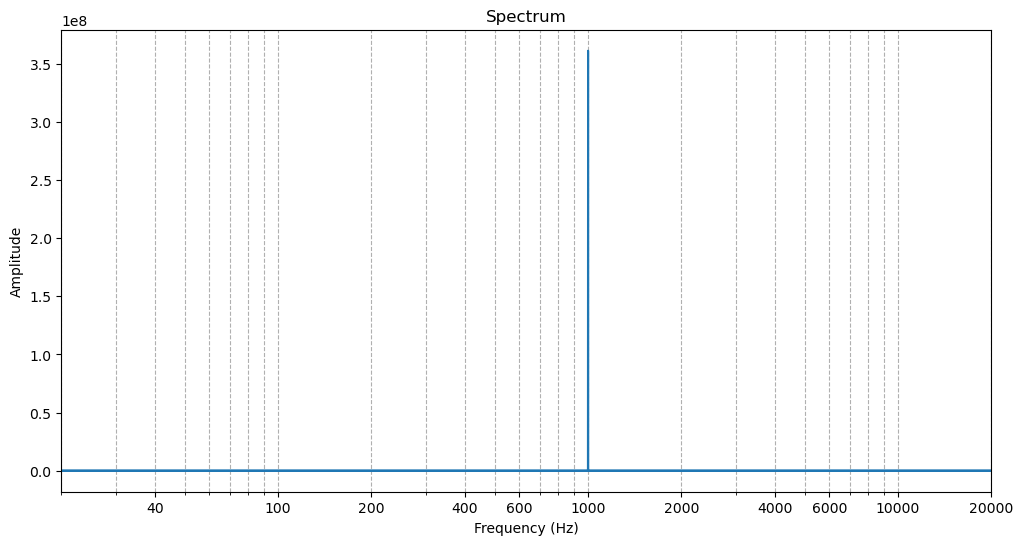

In [32]:
def generate_sine_wave(frequency, duration, sample_rate=44100, amplitude=0.5, bitrate=16):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    waveform = amplitude * np.sin(2 * np.pi * frequency * t)
    if bitrate == 16:
        waveform = np.int16(waveform * 32767)
    if bitrate == 32:
        waveform = np.int32(waveform * 32767)
    audio = AudioSegment(
        waveform.tobytes(),
        frame_rate=sample_rate,
        sample_width=waveform.dtype.itemsize,
        channels=1
    )
    return audio

sine_wave = generate_sine_wave(1000, 1)
#play(sine_wave)
plot_fourier_transformation(sine_wave)

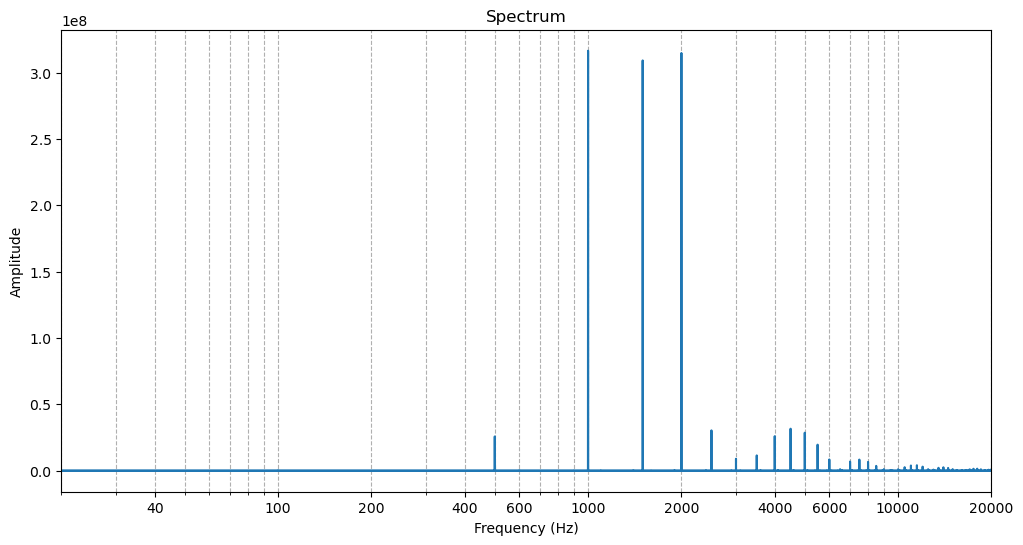

In [33]:
mixed_audio = generate_sine_wave(1000, 1).overlay(generate_sine_wave(1500, 1)).overlay(generate_sine_wave(2000, 1))
#play(mixed_audio)
plot_fourier_transformation(mixed_audio)

This produces some noise but if we raise the bitraite that goes away:

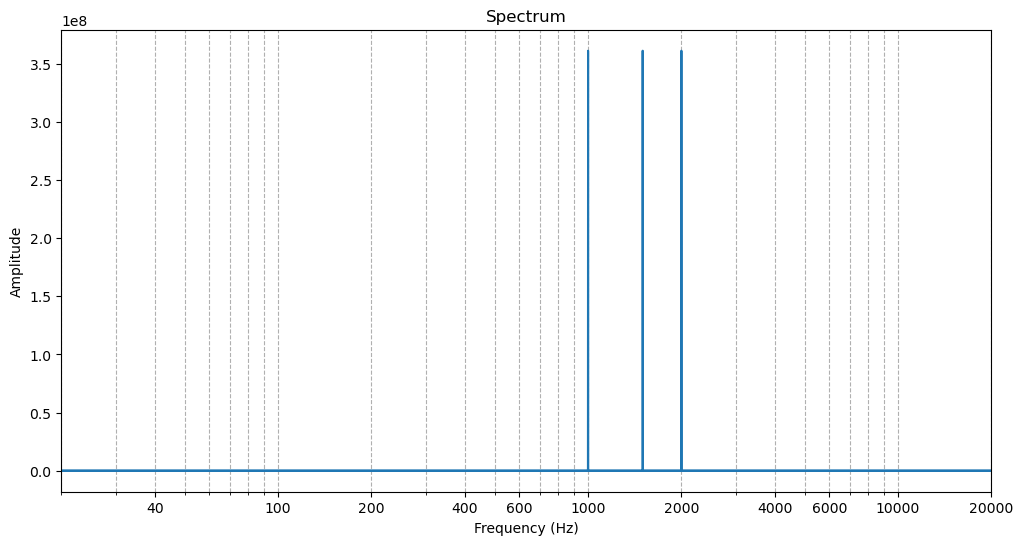

In [34]:
mixed_audio = generate_sine_wave(1000, 1, bitrate=32).overlay(generate_sine_wave(1500, 1, bitrate=32)).overlay(generate_sine_wave(2000, 1, bitrate=32))
plot_fourier_transformation(mixed_audio)

Unfortunately soundcards arent easily set up for int32 bitrates. float32 is possible but complicated, and int24 is possible with soundcards but is complicated with numpy arrays. int16 has some noise but is the easiest to work with in this context.

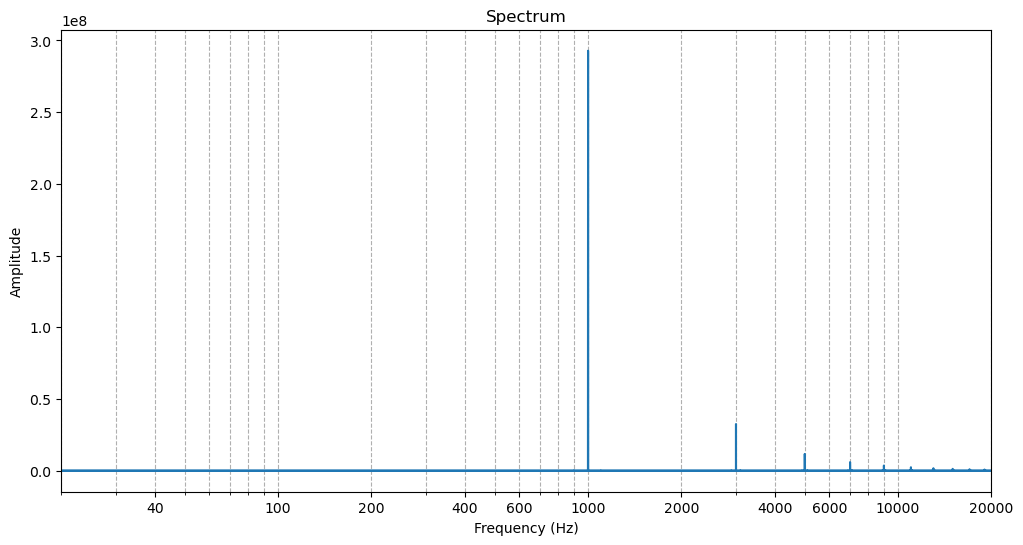

In [35]:
def generate_triangle_wave(frequency, duration, sample_rate=44100, amplitude=0.5, bitrate=16):
    """
    Generate a triangle wave.

    Parameters:
    - frequency: Frequency of the triangle wave in Hz.
    - duration: Duration of the triangle wave in seconds.
    - sample_rate: Sample rate of the audio (default is 44100 Hz).
    - amplitude: Amplitude of the triangle wave (default is 0.5).
    - bitrate: Bitrate of the audio (default is 16 bits).

    Returns:
    - AudioSegment: The generated triangle wave as an AudioSegment object.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    waveform = 2 * amplitude * np.abs(2 * (t * frequency - np.floor(t * frequency + 0.5))) - amplitude
    if bitrate == 16:
        waveform = np.int16(waveform * 32767)
    if bitrate == 32:
        waveform = np.int32(waveform * 32767)
    audio = AudioSegment(
        waveform.tobytes(),
        frame_rate=sample_rate,
        sample_width=waveform.dtype.itemsize,
        channels=1
    )
    return audio

# Example usage
triangle_wave = generate_triangle_wave(1000, 1)
#play(triangle_wave)
plot_fourier_transformation(triangle_wave)

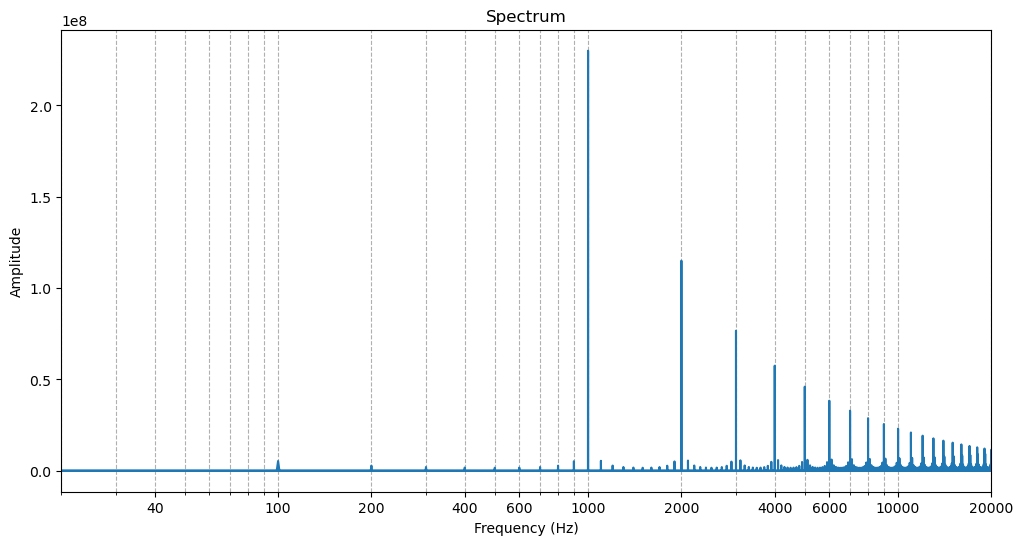

In [36]:
def generate_sawtooth_wave(frequency, duration, sample_rate=44100, amplitude=0.5, bitrate=16):
    """
    Generate a sawtooth wave.

    Parameters:
    - frequency: Frequency of the sawtooth wave in Hz.
    - duration: Duration of the sawtooth wave in seconds.
    - sample_rate: Sample rate of the audio (default is 44100 Hz).
    - amplitude: Amplitude of the sawtooth wave (default is 0.5).
    - bitrate: Bitrate of the audio (default is 16 bits).

    Returns:
    - AudioSegment: The generated sawtooth wave as an AudioSegment object.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    waveform = 2 * amplitude * (t * frequency - np.floor(t * frequency + 0.5))
    if bitrate == 16:
        waveform = np.int16(waveform * 32767)
    if bitrate == 32:
        waveform = np.int32(waveform * 32767)
    audio = AudioSegment(
        waveform.tobytes(),
        frame_rate=sample_rate,
        sample_width=waveform.dtype.itemsize,
        channels=1
    )
    return audio

# Example usage
sawtooth_wave = generate_sawtooth_wave(1000, 1)
#play(sawtooth_wave)
plot_fourier_transformation(sawtooth_wave)

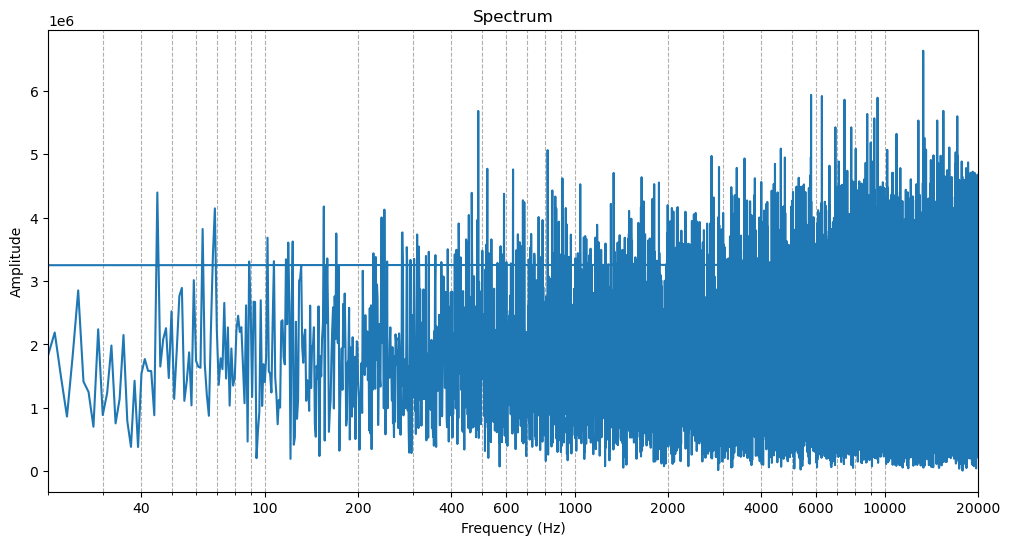

In [37]:
from pydub import AudioSegment
import numpy as np

def generate_white_noise(duration, sample_rate=44100, amplitude=0.5, bitrate=16):
    """
    Generate white noise.

    Parameters:
    - duration: Duration of the white noise in seconds.
    - sample_rate: Sample rate of the audio (default is 44100 Hz).
    - amplitude: Amplitude of the white noise (default is 0.5).
    - bitrate: Bitrate of the audio (default is 16 bits).

    Returns:
    - AudioSegment: The generated white noise as an AudioSegment object.
    """
    # Generate random samples
    samples = np.random.uniform(low=-1.0, high=1.0, size=int(sample_rate * duration))
    if bitrate == 16:
        samples = (samples * amplitude * 32767).astype(np.int16)
    elif bitrate == 32:
        samples = (samples * amplitude * 32767).astype(np.int32)
    
    # Create an AudioSegment
    audio = AudioSegment(
        samples.tobytes(),
        frame_rate=sample_rate,
        sample_width=samples.dtype.itemsize,
        channels=1
    )
    
    return audio

# Example usage
white_noise = generate_white_noise(1, bitrate=16)  # 5 seconds of white noise
#play(white_noise)
plot_fourier_transformation(white_noise)

/var/folders/cj/xlzj5y8n04b93gt4qs_z_g940000gn/T/ipykernel_52789/1881487667.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  log_rms_spectrum[i] = np.mean(bin_values)


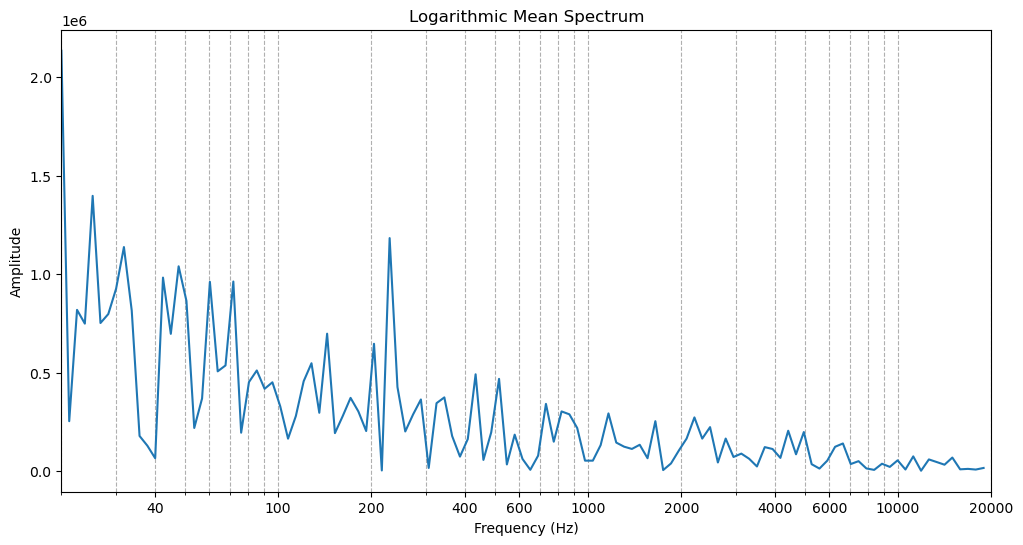

/var/folders/cj/xlzj5y8n04b93gt4qs_z_g940000gn/T/ipykernel_52789/1881487667.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  log_rms_spectrum[i] = np.sum(bin_values)


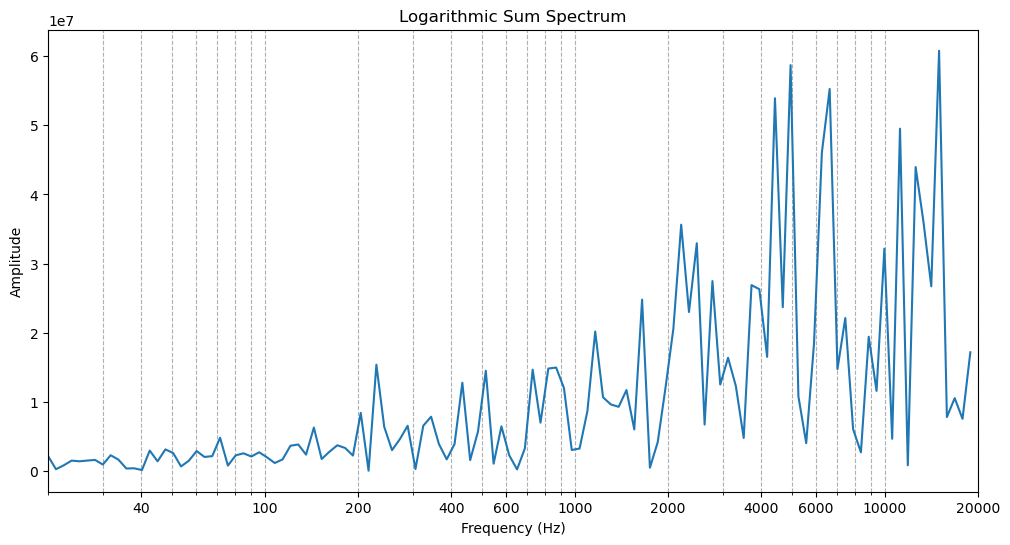

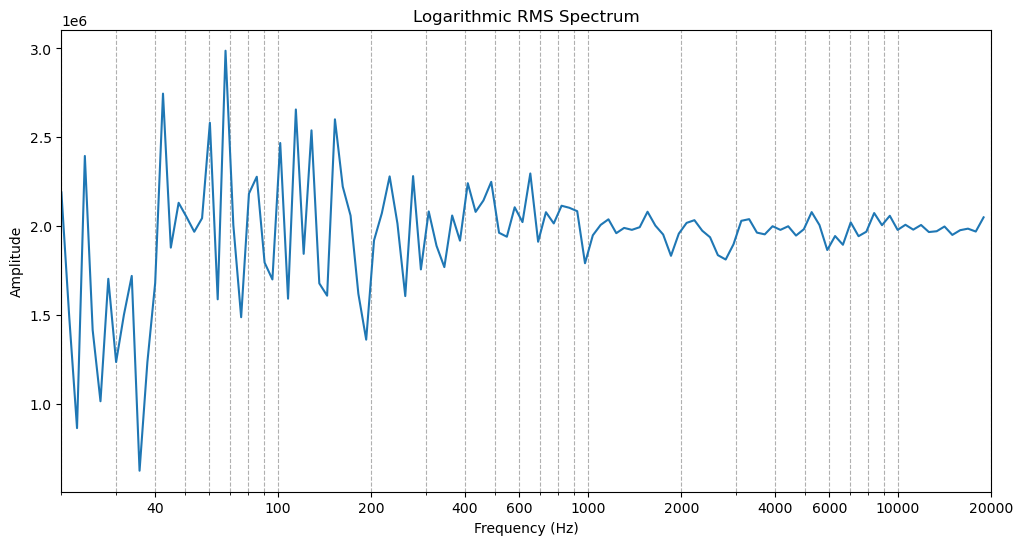

In [38]:
frequencies, fourier = fourier_transform(white_noise)

# Step 3: Define logarithmic bins
min_freq = 20  # Minimum frequency to consider
max_freq = 20000  # Nyquist frequency
num_bins = 120  # Number of logarithmic bins

log_bins = np.logspace(np.log10(min_freq), np.log10(max_freq), num=num_bins)

# Step 4: Group and compute RMS of the complex values
log_rms_spectrum = np.zeros(num_bins - 1)
for i in range(num_bins - 1):
    bin_mask = (frequencies >= log_bins[i]) & (frequencies < log_bins[i + 1])
    if np.any(bin_mask):
        bin_values = fourier[bin_mask]
        log_rms_spectrum[i] = np.mean(bin_values)

plot_frequencies(log_bins[:-1], log_rms_spectrum, title='Logarithmic Mean Spectrum')

# Step 4: Group and compute RMS of the complex values
log_rms_spectrum = np.zeros(num_bins - 1)
for i in range(num_bins - 1):
    bin_mask = (frequencies >= log_bins[i]) & (frequencies < log_bins[i + 1])
    if np.any(bin_mask):
        bin_values = fourier[bin_mask]
        log_rms_spectrum[i] = np.sum(bin_values)

plot_frequencies(log_bins[:-1], log_rms_spectrum, title='Logarithmic Sum Spectrum')


# Step 4: Group and compute RMS of the complex values
log_rms_spectrum = np.zeros(num_bins - 1)
for i in range(num_bins - 1):
    bin_mask = (frequencies >= log_bins[i]) & (frequencies < log_bins[i + 1])
    if np.any(bin_mask):
        bin_values = fourier[bin_mask]
        log_rms_spectrum[i] = np.sqrt(np.mean(np.abs(bin_values)**2))

plot_frequencies(log_bins[:-1], log_rms_spectrum, title='Logarithmic RMS Spectrum')


i literally cant fucking believe ive been able to just free ball this im so glad ive had the audio experiene ive had. lets make a function to simplify a foyer transformaion into a set of logorithmic results


In [39]:
def group_frequencies_rms(frequencies, fourier, min_freq=20, max_freq=20000, num_bins=120):
    log_bins = np.logspace(np.log10(min_freq), np.log10(max_freq), num=num_bins)
    bin_indices = np.digitize(frequencies, log_bins) - 1  # Get bin indices for each frequency
    log_rms_spectrum = np.zeros(num_bins - 1)

    for i in range(num_bins - 1):
        bin_values = fourier[bin_indices == i]
        if bin_values.size > 0:
            log_rms_spectrum[i] = np.sqrt(np.mean(np.abs(bin_values)**2))

    return log_bins[:-1], log_rms_spectrum

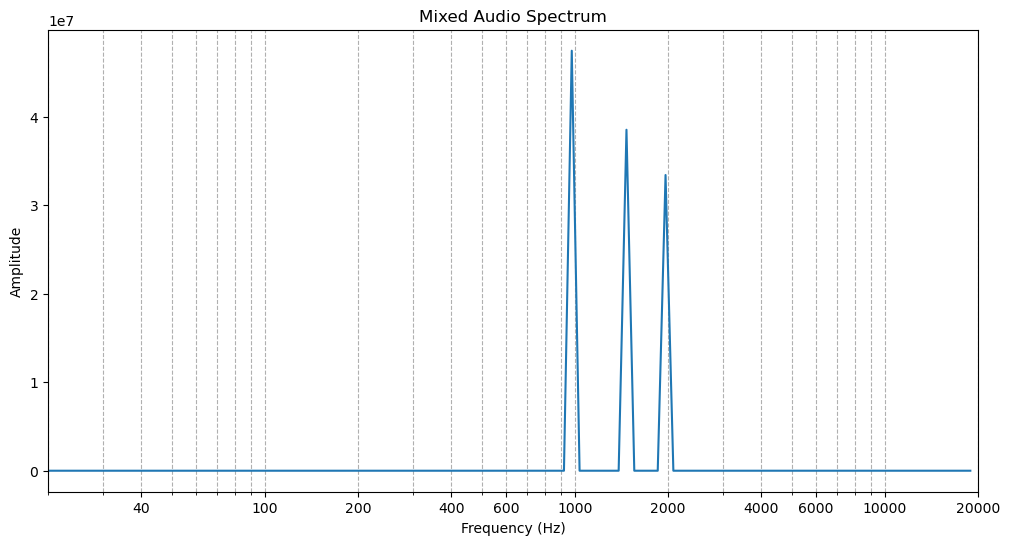

In [41]:
frequencies, fourier = fourier_transform(mixed_audio)
log_bins, log_rms_spectrum = group_frqeuencies_rms(frequencies, fourier)
plot_frequencies(log_bins, log_rms_spectrum, title='Mixed Audio Spectrum')

In [42]:
def plot_fourier_transformation(sound):
    frequencies, fourier = fourier_transform(sound)
    log_bins, log_rms_spectrum = group_frqeuencies_rms(frequencies, fourier)
    plot_frequencies(log_bins, log_rms_spectrum)

## Now performing fourier transformations on our audio files

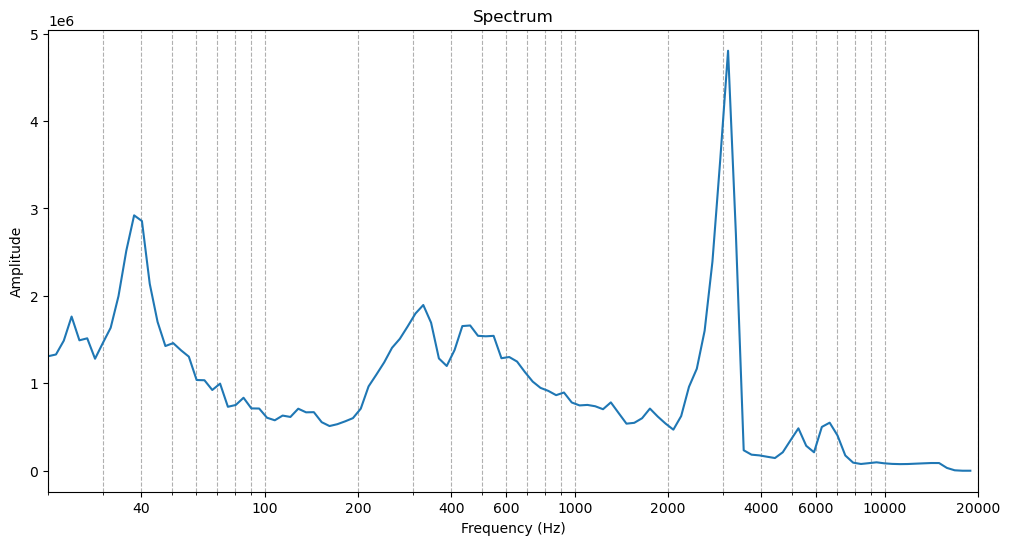

In [43]:
sound = AudioSegment.from_file("Data/birdsong-recognition/train_audio/aldfly/XC2628.mp3", format="mp3")
plot_fourier_transformation(sound)

Seeing this brings me feelings of joy no one could possibly understand.

Question one: If I were to add 120 values columns to this dataframe, how much bigger is it going to get? too big? And how long will it take me to iterate through all that?

In [44]:
# Define the processing function
def process_row(row):
    row_start_time = time.time()
    print('loading:', row['filename'])
    sound = AudioSegment.from_file(f"Data/birdsong-recognition/train_audio/{row['ebird_code']}/{row['filename']}", format="mp3")
    frequencies, fourier = fourier_transform(sound)
    log_bins, log_rms_spectrum = group_frqeuencies_rms(frequencies, fourier)
    result = {}
    for j, bin_value in enumerate(log_bins[:-1]):
        column_name = f"{bin_value:.0f}Hz"
        result[column_name] = log_rms_spectrum[j]
    print('Processed:', row['filename'])
    print(f'Time taken: {time.time() - row_start_time:.2f} seconds')
    return row.name, result

In [45]:
if __name__ == '__main__':
    # Add columns to the dataframe for each element in log_bins
    memory_usage('Data before Frequency Bins', df)
    for bin_value in log_bins:
        column_name = f"{bin_value:.0f}Hz"
        df[column_name] = np.nan  # Initialize with NaN or any default value
        df = df.copy()  # Force pandas to allocate memory for the new column

    # Use ThreadPoolExecutor to process rows in parallel
    start_time = time.time()
    completed_rows = 0  # Counter for completed rows

    with ProcessPoolExecutor(max_workers=6) as executor:  # Adjust max_workers as needed
        futures = {executor.submit(process_row, row): row for _, row in df.iterrows()}
        for future in as_completed(futures):
            i, result = future.result()
            for column_name, value in result.items():
                df.at[i, column_name] = value
            completed_rows += 1
            percent_complete = completed_rows / len(df)
            elapsed_time = time.time() - start_time
            estimated_total_time = elapsed_time / percent_complete
            estimated_time_remaining = estimated_total_time - elapsed_time
            hours, rem = divmod(estimated_time_remaining, 3600)
            minutes, seconds = divmod(rem, 60)
            time_remaining_str = f'{int(hours):02}:{int(minutes):02}:{int(seconds):02}'
            print(f'Estimated time remaining: {time_remaining_str}')
            print(f'Completed rows: {completed_rows}/{len(df)}')
            print('---')

    memory_usage('Data after filling Frequency Bins', df)
    df.to_csv('processed_birdsong_data.csv', index=False)

Data before Frequency Bins Memory Usage: 19.84 MB


Process SpawnProcess-2:
Process SpawnProcess-1:
Process SpawnProcess-3:
Process SpawnProcess-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/quinn/Documents/School/DS270/FinalProject/.conda/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/quinn/Documents/School/DS270/FinalProject/.conda/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/quinn/Documents/School/DS270/FinalProject/.conda/lib/python3.12/concurrent/futures/process.py", line 251, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/quinn/Documents/School/DS270/FinalProject/.conda/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can'

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

Because of this crashing I have decided to replace my conda env with this project with one built in pypy. I'm hoping use of the JIT compiler will speed up cpu intensive loads, and the use of `ThreadPoolExecutor` should reduce i/o loads.

```bash
micromamba create -p ./.pypy -c conda-forge pypy numpy pandas matplotlib ffmpeg
```

going to make a new venv with pypy and everything else we need and run the long processes as seperate files